In [1]:
!rm -rf $PIP_BUILD/watson-machine-learning-client

In [2]:
!pip install --upgrade watson-machine-learning-client

Requirement already up-to-date: watson-machine-learning-client in /opt/conda/envs/Python36/lib/python3.6/site-packages (1.0.378)


In [3]:
wml_credentials = {
    'apikey': 'PMDC8c5Dk99_znMGEafKsQuQUbwKWj2QQ43HnYHuVIjz',
    'url': 'https://us-south.ml.cloud.ibm.com',
    'instance_id': '58e5ae78-3232-4b45-8d5f-339f698a6b73'
}

In [4]:
from watson_machine_learning_client import WatsonMachineLearningAPIClient

In [5]:
client = WatsonMachineLearningAPIClient(wml_credentials)

In [6]:
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)

In [7]:
!pip install --upgrade keras==2.2.5

Requirement already up-to-date: keras==2.2.5 in /opt/conda/envs/Python36/lib/python3.6/site-packages (2.2.5)


In [8]:
import keras
from keras.datasets import mnist

(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [9]:
import matplotlib.pyplot as plt

In [10]:
'''
Paramters of "display_digits" function:

plt     - matplotlib's pyplot module.
images  - The array of images. Ex) X_train, X_test in our example
labels  - Labels of mapping images. 
start   - Start index of "images" array.
end     - End index of "images" array.
num_row - Number of rows.
title   - Title of every image that will be displayed. Ex) Training or Test
'''
def display_digits(plt, images, labels, start, end, num_row, title):
    images_and_labels = list(zip(images, labels))
    num_col = int(end/num_row) if (end % 2 == 0) else int(end/num_row) + 1

    for index, (image, label) in enumerate(images_and_labels[start:end]):
        plt.subplot(num_row, num_col, index + 1)
        plt.axis('off')
        plt.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
        plt.title(title + ': %i' % label)

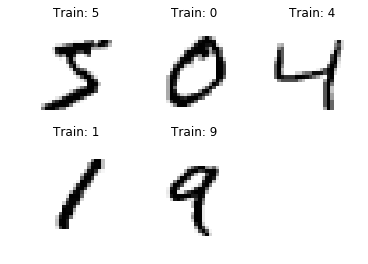

In [11]:
display_digits(plt, X_train, y_train, 0, 5, 2, 'Train')

In [12]:
print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)
print('X_test shape:', X_test.shape)
print('y_test shape:', y_test.shape)

X_train shape: (60000, 28, 28)
y_train shape: (60000,)
X_test shape: (10000, 28, 28)
y_test shape: (10000,)


In [13]:
X_test_score = X_test.copy()
y_test_score = y_test.copy()

In [14]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

In [15]:
batch_size = 128
num_classes = 10
epochs = 6

In [16]:
img_rows, img_cols = 28, 28

In [17]:
if K.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

In [18]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

In [19]:
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [20]:
model = Sequential()
model.add(Conv2D(32, 
                 kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

In [21]:
history = model.fit(X_train,
          y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/6
60000/60000 [==============================] - 183s 3ms/step - loss: 0.2636 - acc: 0.9183 - val_loss: 0.0550 - val_acc: 0.9821
Epoch 2/6
60000/60000 [==============================] - 188s 3ms/step - loss: 0.0890 - acc: 0.9731 - val_loss: 0.0414 - val_acc: 0.9858
Epoch 3/6
60000/60000 [==============================] - 183s 3ms/step - loss: 0.0667 - acc: 0.9795 - val_loss: 0.0344 - val_acc: 0.9884
Epoch 4/6
60000/60000 [==============================] - 181s 3ms/step - loss: 0.0562 - acc: 0.9831 - val_loss: 0.0315 - val_acc: 0.9887
Epoch 5/6
60000/60000 [==============================] - 182s 3ms/step - loss: 0.0461 - acc: 0.9859 - val_loss: 0.0330 - val_acc: 0.9890
Epoch 6/6
60000/60000 [==============================] - 183s 3ms/step - loss: 0.0411 - acc: 0.9876 - val_loss: 0.0261 - val_acc: 0.9911


In [22]:
plt.style.use('ggplot')

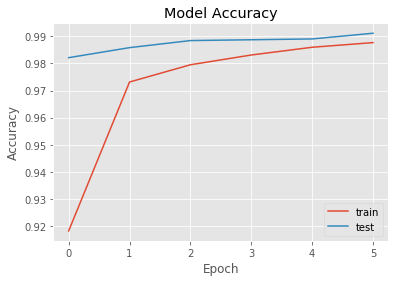

In [23]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='lower right')

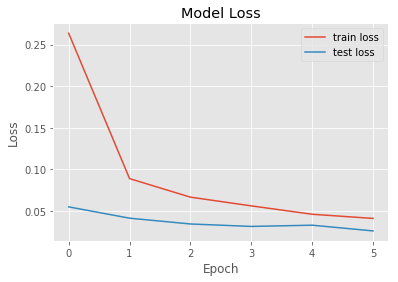

In [24]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train loss', 'test loss'], loc='upper right')

In [25]:
score = model.evaluate(X_test, y_test, verbose=0)

In [26]:
print('Test loss:', score[0])
print('Test accuracy: {:.2f}%'.format(score[1]*100))

Test loss: 0.026097533438885875
Test accuracy: 99.11%


In [27]:
from contextlib import suppress
import os

filename = 'keras_mnist_model.h5'

# Delete a duplicate file if exists.
with suppress(OSError):
    os.remove(filename)
    
model.save(filename)

In [28]:
#compress keras model
tar_filename = filename + '.tgz'
cmdstring = 'tar -zcvf ' + tar_filename + ' ' + filename
os.system(cmdstring)

0

In [29]:
!ls

keras_mnist_model.h5  keras_mnist_model.h5.tgz


In [30]:
client = WatsonMachineLearningAPIClient(wml_credentials)

In [31]:
model_props = {
    client.repository.ModelMetaNames.NAME: 'MNIST - compressed keras model',
    client.repository.ModelMetaNames.FRAMEWORK_NAME: 'tensorflow',
    client.repository.ModelMetaNames.FRAMEWORK_VERSION: '1.15',
    client.repository.ModelMetaNames.RUNTIME_NAME: 'python',
    client.repository.ModelMetaNames.RUNTIME_VERSION: '3.6',
    client.repository.ModelMetaNames.FRAMEWORK_LIBRARIES: [{'name':'keras', 'version': '2.2.5'}]
}

published_model_details = client.repository.store_model(model=tar_filename, meta_props=model_props)       


In [32]:
model_uid = client.repository.get_model_uid(published_model_details)
print(model_uid)

08e7e475-553d-4bdd-9370-f462e10cd092


In [33]:
deployment = client.deployments.create(model_uid, 'Keras MNIST model deployment through compressed file.')



#######################################################################################

Synchronous deployment creation for uid: '08e7e475-553d-4bdd-9370-f462e10cd092' started

#######################################################################################


INITIALIZING
DEPLOY_IN_PROGRESS
DEPLOY_SUCCESS


------------------------------------------------------------------------------------------------
Successfully finished deployment creation, deployment_uid='8a7d3466-1927-43ba-94ad-fc99b332ef67'
------------------------------------------------------------------------------------------------




In [34]:
client.deployments.list()

------------------------------------  -----------------------------------------------------  ------  --------------  ------------------------  ---------------  -------------
GUID                                  NAME                                                   TYPE    STATE           CREATED                   FRAMEWORK        ARTIFACT TYPE
8a7d3466-1927-43ba-94ad-fc99b332ef67  Keras MNIST model deployment through compressed file.  online  DEPLOY_SUCCESS  2020-06-05T04:55:06.203Z  tensorflow-1.15  model
5a2e9778-16bb-408d-bbbb-30ed3558f56e  Keras MNIST model deployment through compressed file.  online  DEPLOY_SUCCESS  2020-06-05T04:32:56.462Z  tensorflow-1.15  model
------------------------------------  -----------------------------------------------------  ------  --------------  ------------------------  ---------------  -------------


In [35]:
scoring_endpoint = client.deployments.get_scoring_url(deployment)
print(scoring_endpoint)

https://us-south.ml.cloud.ibm.com/v3/wml_instances/58e5ae78-3232-4b45-8d5f-339f698a6b73/deployments/8a7d3466-1927-43ba-94ad-fc99b332ef67/online


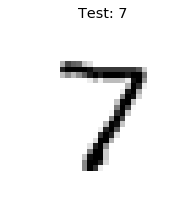

In [36]:
scoring_data = X_test[0].tolist()
display_digits(plt, X_test_score, y_test_score, 0, 1, 1, 'Test')

In [37]:
scoring_payload = {'values': [scoring_data]}
scores = client.deployments.score(scoring_endpoint, scoring_payload)

In [38]:
print(str(scores))

{'fields': ['prediction', 'prediction_classes', 'probability'], 'values': [[[5.310140521741502e-11, 1.7868504453844025e-09, 1.532134241699623e-08, 9.630891639744732e-08, 9.526210376087363e-11, 1.5684932519466344e-10, 2.0394757660035373e-13, 0.9999995231628418, 3.481135379956868e-10, 3.398483556793508e-07], 7, [5.310140521741502e-11, 1.7868504453844025e-09, 1.532134241699623e-08, 9.630891639744732e-08, 9.526210376087363e-11, 1.5684932519466344e-10, 2.0394757660035373e-13, 0.9999995231628418, 3.481135379956868e-10, 3.398483556793508e-07]]]}
